# 6 PCA - Task 1

Use all collected ratings to derive possible dimension and item loadings of interpersonal speaker characteristics.
Note that also an inverse interpretation of the ratings is possible.
Please split the data in male and female speakers before performing the factor analysis.
File to use: likeability_dimension_ratings.csv

## Import and initialize

In [34]:
import numpy as np
import pandas as pd

# !pip3 install sklearn --user
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# !pip3 install factor_analyzer --user
from factor_analyzer.utils import corr, impute_values, partial_correlations, smc
from factor_analyzer.factor_analyzer import calculate_kmo

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", context="talk")

FIGSIZE = (20,4)

## Loading the data

In [29]:
# extract only the neccessary columns:
# 7: speaker gender
# 9-42: speacker characteristics
columns = [7] + list(range(9, 43))

ds_path = "../datasets/DB02_speaker_likeability_dimension_ratings.csv"
dataset_reduced = pd.read_csv(ds_path, usecols=columns).dropna()
dataset_reduced

,speaker_gender,unsympatisch,sicher,attraktiv,verstaendnislos,unentschieden,unaufdringlich,distanziert,gelangweilt,emotional,...,freundlich,maennlich,gehorsam,gleichgueltig,interessant,zynisch,aufgesetzt,intelligent,kindlich,bescheiden
0,female,18,79,83,86,18,72,12,18,64,...,78,10,67,75,76,26,12,87,60,71
1,female,0,100,100,0,0,100,0,0,29,...,100,100,100,0,100,0,0,83,70,100
2,female,19,62,43,19,39,84,19,33,56,...,81,0,86,42,53,16,22,67,38,81
3,female,33,56,57,44,34,30,41,40,56,...,72,5,40,24,63,62,29,57,30,47
4,female,100,32,0,28,81,87,76,67,16,...,79,28,87,25,28,77,79,70,74,83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4514,female,41,7,96,35,90,57,32,40,70,...,80,5,73,31,63,29,59,58,58,28
4515,female,31,81,62,57,33,38,12,70,15,...,40,3,69,64,31,74,59,35,45,28
4516,female,25,100,62,42,28,32,46,60,33,...,78,0,16,74,20,83,28,83,0,38
4517,female,32,68,64,32,31,66,32,33,69,...,58,4,31,28,67,65,25,66,28,38


## Splitting the dataset into male and female speakers

In [30]:
characteristics = {
    gender: dataset_reduced[dataset_reduced['speaker_gender'] == gender]
    for gender in dataset_reduced['speaker_gender'].unique()
}

# remove unnecessary column
for df in characteristics.values():
    del df['speaker_gender']

## Step 1: Check if PCA can be done with KMO test

In [31]:
# calculate_kmo() returns tuple with:
# 0: score per variable
# 1: total score
for gender, data in characteristics.items():
    kmo = calculate_kmo(data)[1]
    print(f"KMO test for {gender} speakers {kmo:.2f}. Criterion >0.5? {kmo > 0.5}")

KMO test for female speakers 0.93. Criterion >0.5? True
KMO test for male speakers 0.92. Criterion >0.5? True


## Step 2: Calculate Eigenvalues 

In [32]:
eigenvalues = {}
for gender, data in characteristics.items():
    covariance = np.cov(data.T)
    eigval = np.linalg.eigvalsh(covariance)
    eigval.sort()  # sorts in ascending order
    eigval = np.flip(eigval)
    eigenvalues[gender] = eigval.real #  use real component only

## Step 3: Decide on number of factors

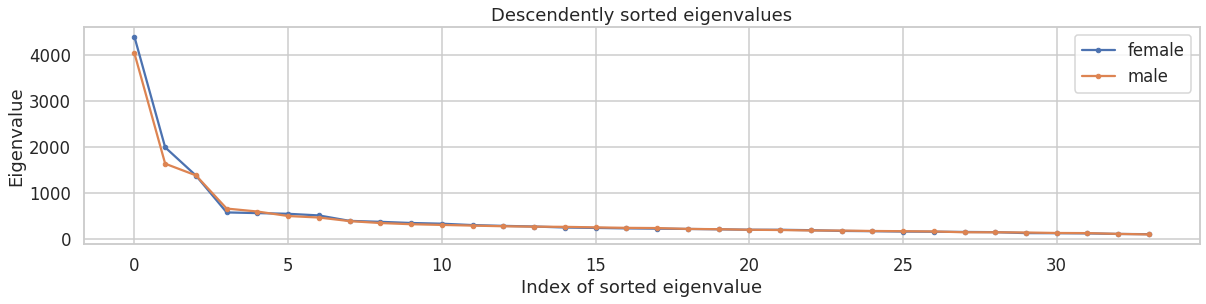

In [35]:
fig, ax = plt.subplots(figsize=FIGSIZE)

for gender, eigvals in eigenvalues.items():
    ax.plot(eigvals, ".-", label=gender)

ax.set_xlabel("Index of sorted eigenvalue")
ax.set_ylabel("Eigenvalue")
ax.set_title("Descendently sorted eigenvalues")
ax.legend()
None

### Interpretation
**Point of infliction**: 4 components

## Step 4: Perform PCA

In [42]:
NUM_COMPONENTS = 4
pca = {}
factored = {}
for gender, data in characteristics.items():
    pca[gender] = PCA(n_components=NUM_COMPONENTS)
    factored[gender] = pca[gender].fit_transform(data)

### Visualize factored data

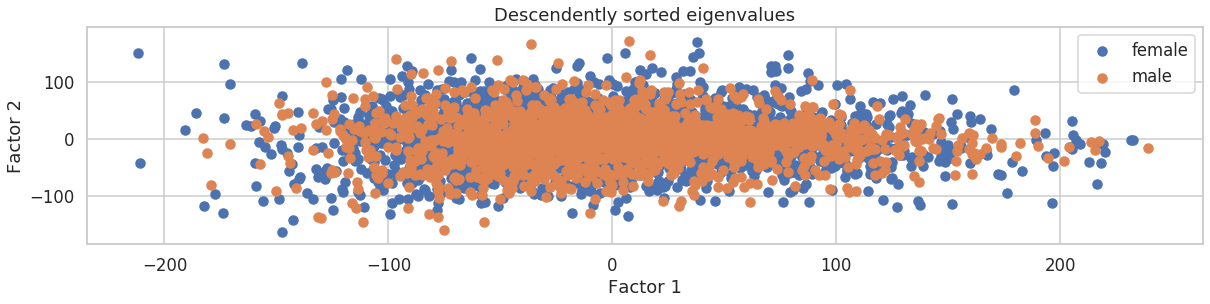

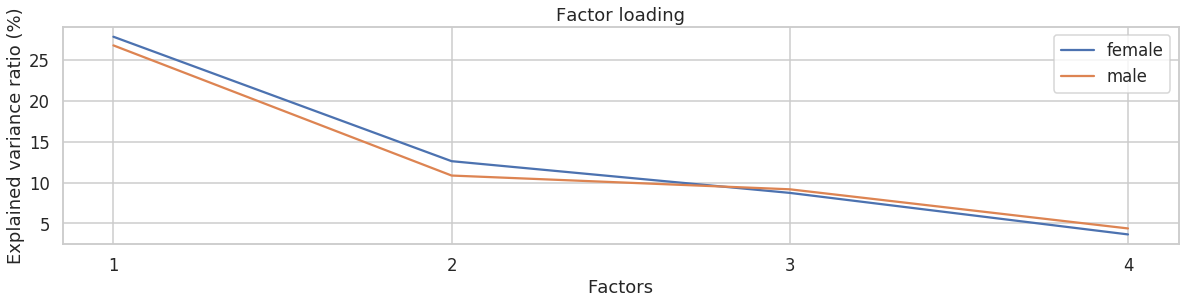

In [54]:
fig, ax = plt.subplots(figsize=FIGSIZE)

for gender, data in factored.items():
    ax.scatter(data[:, 0], data[:, 1], label=gender)

ax.set_xlabel("Factor 1")
ax.set_ylabel("Factor 2")
ax.set_title("")
ax.legend()
None

fig, ax = plt.subplots(figsize=FIGSIZE)

for gender, model in pca.items():
    x = range(1, model.n_components + 1)
    ax.plot(x, model.explained_variance_ratio_ * 100, label=gender)
    ax.set_xticks(x)

ax.set_xlabel("Factors")
ax.set_ylabel("Explained variance ratio (%)")
ax.set_title("Factor loading")
ax.legend()
None

## Step 5: Check Cronbach's alpha

In [44]:
#Source: https://stackoverflow.com/a/20799687
def cronbach(itemscores):
    itemvars = itemscores.var(axis=1, ddof=1)
    tscores = itemscores.sum(axis=0)
    nitems = len(itemscores)
    return nitems / (nitems-1) * (1 - itemvars.sum() / tscores.var(ddof=1))

In [60]:
for gender in factored:
    original = characteristics[gender]
    transformed = factored[gender]
    ca_original = cronbach(original)
    ca_transformed = cronbach(transformed.T)
    print(f"Cronbach's alpha of {gender} speaker:")
    print(f"\tOriginal dimensionality: {ca_original:f}")
    print(f"\tReduced dimensionality: {ca_transformed:f}")

Cronbach's alpha of female speaker:
	Original dimensionality: 0.997410
	Reduced dimensionality: 0.000000
Cronbach's alpha of male speaker:
	Original dimensionality: 0.996323
	Reduced dimensionality: -0.000000
